In [ ]:
import tensorflow as tf
import numpy as np
import json

import random
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns


from google.colab import drive
import os
# Mount Google Drive for access
drive.mount('/content/drive')
from sklearn.preprocessing import StandardScaler






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from JSON files
with open('/content/drive/MyDrive/My-207/X_train_mfcc_aug.json', 'r') as file:
    X_train = json.load(file)
with open('/content/drive/MyDrive/My-207/y_train_mfcc_aug.json', 'r') as file:
    y_train = json.load(file)
with open('/content/drive/MyDrive/My-207/X_val_mfcc_aug.json', 'r') as file:
    X_val = json.load(file)
with open('/content/drive/MyDrive/My-207/y_val_mfcc_aug.json', 'r') as file:
    y_val = json.load(file)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Normalize features
from sklearn.preprocessing import MinMaxScaler

train_X_reshape = X_train.reshape(-1, 20*157)
val_X_reshape = X_val.reshape(-1, 20*157)

scaler = MinMaxScaler((0,1)).fit(train_X_reshape)

train_X_scaled = scaler.transform(train_X_reshape)
val_X_scaled = scaler.transform(val_X_reshape)

X_train = train_X_scaled.reshape(-1,20,157)
X_val = val_X_scaled.reshape(-1,20,157)

print(X_train.shape)
print(X_val.shape)

# Ensure all sequences in the list have the same length
X_train = pad_sequences(X_train, dtype='float32', padding='post')
X_val = pad_sequences(X_val, dtype='float32', padding='post')

In [ ]:
# swap the x and y axis so doing convolution on the time dimension
train_X_perm = []
for each in X_train:
  train_X_perm.append(np.transpose(each))

X_train = np.array(train_X_perm)

val_X_perm = []
for each in X_val:
  val_X_perm.append(np.transpose(each))

X_val = np.array(val_X_perm)

print(X_train.shape)
print(X_val.shape)

In [ ]:
# Encode labels to integers
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Define LSTM model
model = models.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train_pad.shape[1], X_train_pad.shape[2]), kernel_regularizer=l2(0.01)))
model.add(layers.LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(np.unique(y_train_encoded)), activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit(X_train_pad, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_val_pad, y_val_encoded), shuffle=True)


Epoch 1/20
247/247 [==============================] - 14s 36ms/step - loss: 1.8543 - accuracy: 0.4324 - val_loss: 1.2047 - val_accuracy: 0.4585
Epoch 2/20
247/247 [==============================] - 10s 40ms/step - loss: 1.0893 - accuracy: 0.5100 - val_loss: 1.1341 - val_accuracy: 0.4358
Epoch 3/20
247/247 [==============================] - 8s 33ms/step - loss: 0.9978 - accuracy: 0.5541 - val_loss: 1.0524 - val_accuracy: 0.5005
Epoch 4/20
247/247 [==============================] - 9s 35ms/step - loss: 0.9509 - accuracy: 0.5835 - val_loss: 1.0724 - val_accuracy: 0.4768
Epoch 5/20
247/247 [==============================] - 11s 46ms/step - loss: 0.9032 - accuracy: 0.6183 - val_loss: 1.1668 - val_accuracy: 0.4444
Epoch 6/20
247/247 [==============================] - 8s 31ms/step - loss: 0.8645 - accuracy: 0.6351 - val_loss: 1.1651 - val_accuracy: 0.4531
Epoch 7/20
247/247 [==============================] - 11s 43ms/step - loss: 0.8270 - accuracy: 0.6689 - val_loss: 1.1162 - val_accuracy: 0.

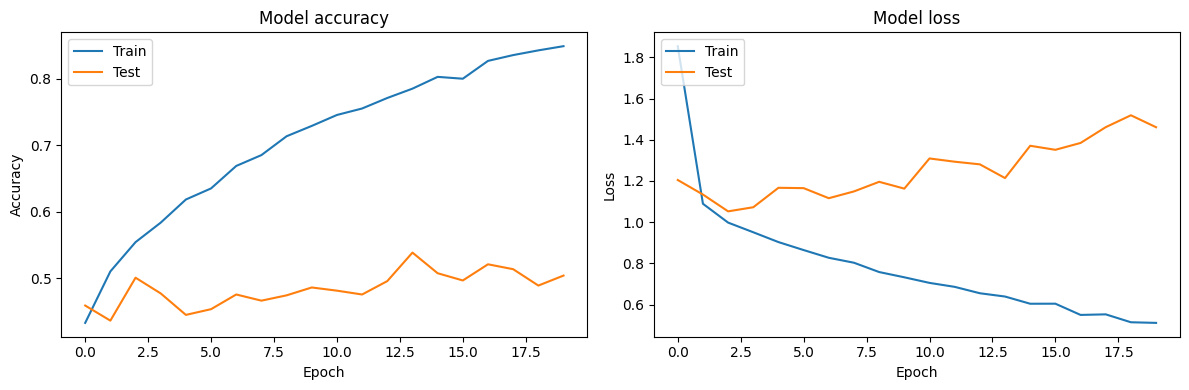

98/98 [==============================] - 2s 13ms/step
F1 score on validation set:  0.5025041531014265


In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.show()

# Predicting the set results
y_pred = model.predict(X_val_pad)
y_pred = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_val_encoded, y_pred)



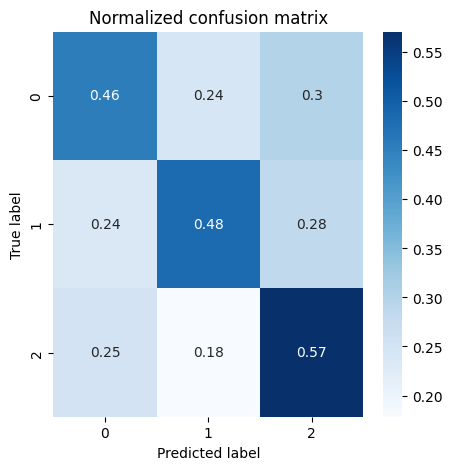

F1 score on validation set:  0.5025041531014265


In [ ]:
# Normalize confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(5,5))

# Create a heatmap
sns.heatmap(cm_norm, annot=True, cmap='Blues')

plt.title('Normalized confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

# Calculate F1 score
f1 = f1_score(y_val_encoded, y_pred, average='weighted')
print('F1 score on validation set: ', f1)


In [ ]:
from sklearn.metrics import classification_report

# Get the class names from the label encoder
class_names = encoder.classes_

# Calculate per-class accuracy from the confusion matrix
per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

# Print the per-class accuracy with actual class names
for i, accuracy in enumerate(per_class_accuracy):
    print(f"Accuracy for {class_names[i]}: {accuracy}")

# Use classification_report with actual class names
print(classification_report(y_val_encoded, y_pred, target_names=class_names))


Accuracy for barswa: 0.45549242424242425
Accuracy for comsan: 0.48045267489711935
Accuracy for eaywag1: 0.5709057639524245
              precision    recall  f1-score   support

      barswa       0.49      0.46      0.47      1056
      comsan       0.51      0.48      0.49       972
     eaywag1       0.51      0.57      0.54      1093

    accuracy                           0.50      3121
   macro avg       0.50      0.50      0.50      3121
weighted avg       0.50      0.50      0.50      3121

